In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [42]:
train_source = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')

test_source = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')


############################
# Make new feature 'title' #
############################

# extract title from name
title_list = train_source.Name.str.extract('([A-Za-z]+)\.', expand=False)
train_source['title'] = title_list
test_source['title'] = title_list

# change some to Miss and Mrs
train_source['title'] = train_source['title'].replace('Mlle','Miss')
train_source['title'] = train_source['title'].replace('Ms','Miss')
train_source['title'] = train_source['title'].replace('Mme','Mrs')

test_source['title'] = test_source['title'].replace('Mlle','Miss')
test_source['title'] = test_source['title'].replace('Ms','Miss')
test_source['title'] = test_source['title'].replace('Mme','Mrs')

# combine title with small counts to 'Other'
small_title = train_source.title.value_counts().index[train_source.title.value_counts() < 5]

train_source['title'] = train_source['title'].replace(small_title,'Other')
test_source['title'] = test_source['title'].replace(small_title,'Other')

train_source['title'] = train_source['title'].replace('Dr','Other')
test_source['title'] = test_source['title'].replace('Dr','Other')


train = train_source
test = test_source

train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss


## Exploratory Analysis
* In the training data, 'not survive' is majority
* There are more male than female. But, out of people survived, there are ***twice more female than male***

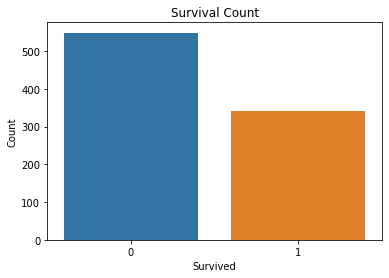

In [43]:
# survival count
sns.countplot(train_source.Survived)
plt.title('Survival Count')
plt.ylabel('Count')
plt.show()

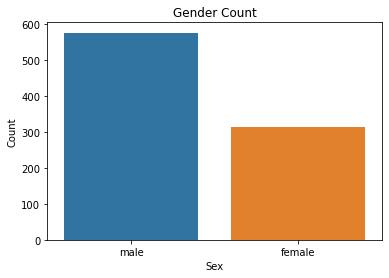

In [44]:
# count by gender
sns.countplot(train.Sex)
plt.title('Gender Count')
plt.ylabel('Count')
plt.show()

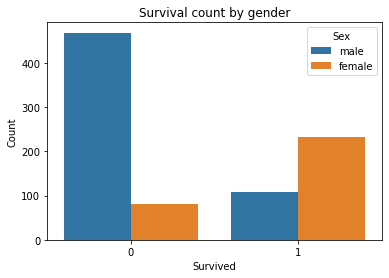

In [45]:
# survival count by gender
sns.countplot(train.Survived, hue=train.Sex)
plt.title('Survival count by gender')
plt.ylabel('Count')
plt.show()

# Title vs Survivability
* After cleaning up the names, the titles of passengers were extracted, and their survival rate is calculated
* 'Other' refer to titles that occured very few times
* 'Miss' 'Mrs' 'Master' seemed to have a higher survival rate, this could be evidence of 'let women and children go first'
* 'Rev' refers to 'Reverend', those are Christian clergy and ministers, and all of them gave their life

        Survived
title           
Master  0.575000
Miss    0.702703
Mr      0.156673
Mrs     0.793651
Other   0.470588
Rev     0.000000


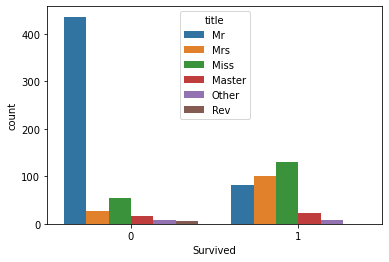

In [46]:
# survival count by title
print(pd.DataFrame(train_source[['title','Survived']].groupby('title').mean()))

sns.countplot(train_source.Survived, hue = train_source.title)
plt.show()

* People embarked from ***Cherbourg*** "seems" to be have higher chance surviving

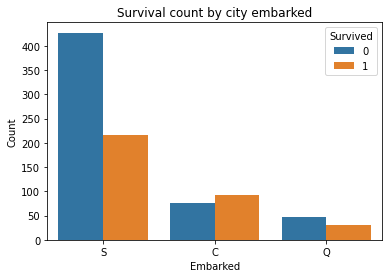

In [47]:
# survival count by embarked
sns.countplot(train.Embarked, hue=train.Survived)
plt.title('Survival count by city embarked')
plt.ylabel('Count')
plt.show()

# Age vs Survivability
* Age of passengers are somewhat normally distributed (with a lot infants)
* Survivability does vary with age.
* There is more chance for ***infants (age = 0)*** to survive
* Young people (around age 20) tend to not survive
* A decent number of old people survived

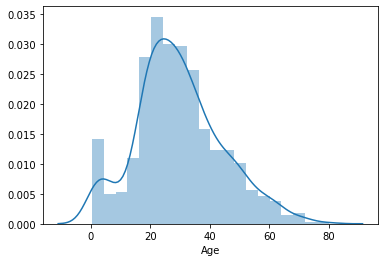

In [48]:
# distribution of age
sns.distplot(train.Age)
plt.show()

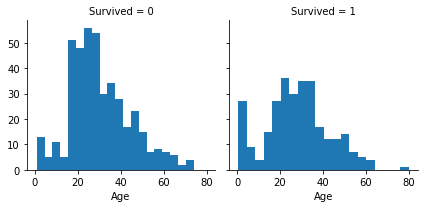

In [49]:
# plot age vs survived
aa = sns.FacetGrid(train,col = 'Survived')
aa.map(plt.hist, 'Age', bins = 20)
plt.show()

# Family size vs Survivability
* If one has 0 siblings / parent/ children, its ***less likely*** to survive
* Around 1/2 of passengers are 3rd class, 1/4 each for 1st and 2nd class. Death is ***3 times higher for 3rd class, lower for 1st class, about same for 2nd class***.


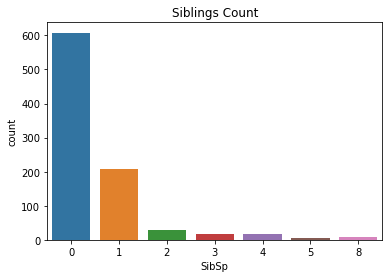

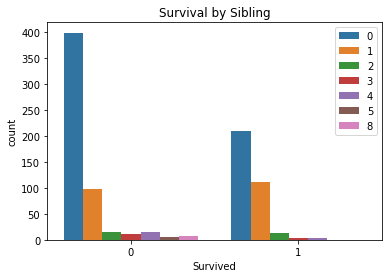

In [50]:
# siblings count
sns.countplot(train.SibSp)
plt.title('Siblings Count')
plt.show()
#print(train.SibSp.value_counts())

# surviveal by sibling count
sns.countplot(train.Survived, hue=train.SibSp)
plt.title('Survival by Sibling')
plt.legend(loc='upper right')
plt.show()

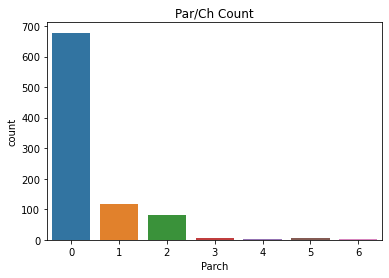

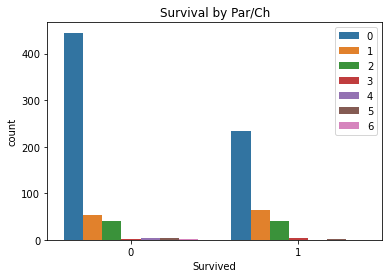

In [51]:
# parent/children count
sns.countplot(train.Parch)
plt.title('Par/Ch Count')
plt.show()
#print(train.Parch.value_counts())

# surviveal by parent/children count
sns.countplot(train.Survived, hue=train.Parch)
plt.title('Survival by Par/Ch')
plt.legend(loc='upper right')
plt.show()

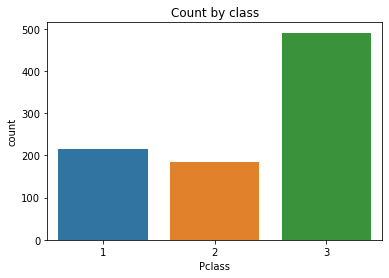

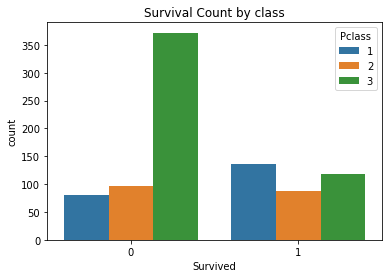

In [52]:
# by class
sns.countplot(train.Pclass)
plt.title('Count by class')
plt.show()

sns.countplot(train.Survived, hue = train.Pclass)
plt.title('Survival Count by class')
plt.show()

* There are significantly more young people in Class 3, and majority of them did not survive
* Further enchances the fact that surviving is related to class and age

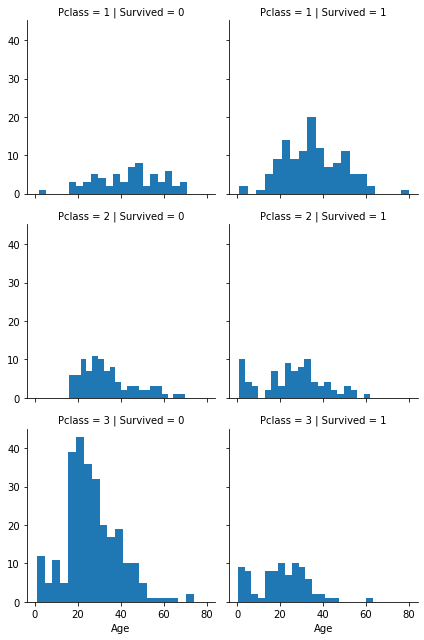

In [53]:
# age by class / survived
aa = sns.FacetGrid(train, col = 'Survived', row = 'Pclass')
aa.map(plt.hist, 'Age', bins = 20)
plt.show()

* Fare is highly skewed
* Some tickets in class 1 are extremely high (>500)

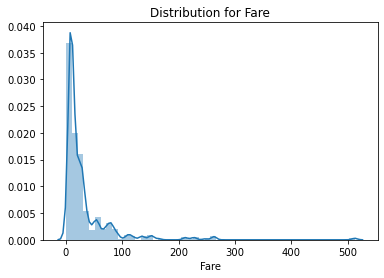

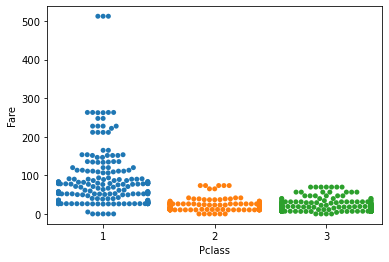

In [54]:
# histogram for fare
sns.distplot(train.Fare)
plt.title('Distribution for Fare')
plt.show()

# scatterplot for fare and class
sns.swarmplot(x=train.Pclass, y=train.Fare)
plt.show()

# Correlation between variables
* Class and Fare are negative correlated (this is expected)
* Surviving is somewhat related to family size, fare, class, but not too obvious, further data cleaning is needed

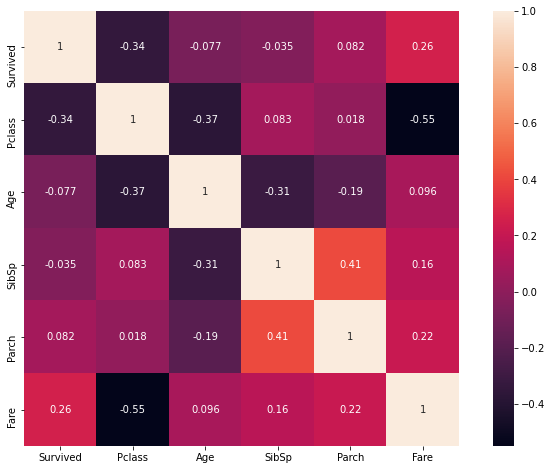

In [55]:
corr = train.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, square=True)

plt.show()